<a href="https://colab.research.google.com/github/bigarcia/pece_eEDB-001_mineiracao_de_dados/blob/main/Projeto_Final_Previs%C3%A3o_de_Cancelamento_de_Reservas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Projeto Final - Previsão de Cancelamento de Reservas

### Alunos
Bianca Martins
Leander Silveira
Lucas Silva
Rodrigo Pedrosa

### Introdução
O setor hoteleiro enfrenta grandes desafios relacionados ao cancelamento de reservas, que podem impactar diretamente na lucratividade e eficiência operacional. Este trabalho utiliza técnicas de mineração de dados para prever cancelamentos com base em dados históricos de reservas, permitindo que hotéis criem estratégias proativas para mitigar esses impactos.

### Objetivo
1. Prever se uma reserva será cancelada com base em variáveis históricas.
2. Identificar os fatores mais relevantes que contribuem para o cancelamento.
3. Propor soluções baseadas nos resultados para mitigar cancelamentos e melhorar a eficiência.


---
### Dataset

O dataset utilizado contém dados de reservas de hotéis e pode ser acessado pelo link do Kaggle: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import kagglehub


## 1. Carregar o Dataset


   Nesta etapa, o conjunto de dados foi importado de uma fonte externa (Kaggle) e carregado em um DataFrame. Foram realizadas verificações iniciais para entender a estrutura dos dados, como colunas disponíveis, tipos de dados e presença de valores ausentes


   - **Tamanho do dataset original**: **119.390 registros**.

In [20]:
path = kagglehub.dataset_download("jessemostipak/hotel-booking-demand")
print("Path to dataset files:", path)
dataset_path = f"{path}/hotel_bookings.csv"

data = pd.read_csv(dataset_path)


data.head()

Path to dataset files: /root/.cache/kagglehub/datasets/jessemostipak/hotel-booking-demand/versions/1


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## 2. Análise Exploratória de Dados (EDA)


A EDA foi utilizada para explorar os padrões nos dados e identificar relações entre variáveis. Visualizações como gráficos de distribuição e matriz de correlação ajudaram a destacar os fatores mais influentes no cancelamento de reservas, enquanto a análise estatística revelou inconsistências ou outliers. Também foram verificadas métricas como a proporção de reservas canceladas e não canceladas.

In [21]:
print("Informações do dataset:")
print(data.info())

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64

In [22]:
print("Estatísticas descritivas:")
print(data.describe())

Estatísticas descritivas:
         is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%              

In [23]:
# Verificar a quantidade de valores nulos por coluna
print("Valores nulos por coluna:")
print(data.isnull().sum())

Valores nulos por coluna:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                          

In [24]:
# Excluir colunas irrelevantes ou com muitos valores nulos
# Remoção das colunas 'company', 'agent' e 'reservation_status_date', que não são necessárias.
data = data.drop(['company', 'agent', 'reservation_status_date'], axis=1)

# Substituir valores nulos
data['children'] = data['children'].fillna(0)

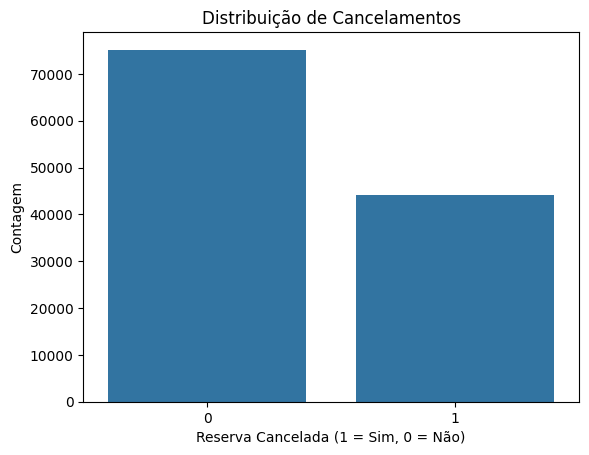

In [25]:
# Visualização da distribuição de reservas canceladas e não canceladas.
def plot_cancel_distribution(data):
    sns.countplot(x='is_canceled', data=data)
    plt.title('Distribuição de Cancelamentos')
    plt.xlabel('Reserva Cancelada (1 = Sim, 0 = Não)')
    plt.ylabel('Contagem')
    plt.show()

plot_cancel_distribution(data)

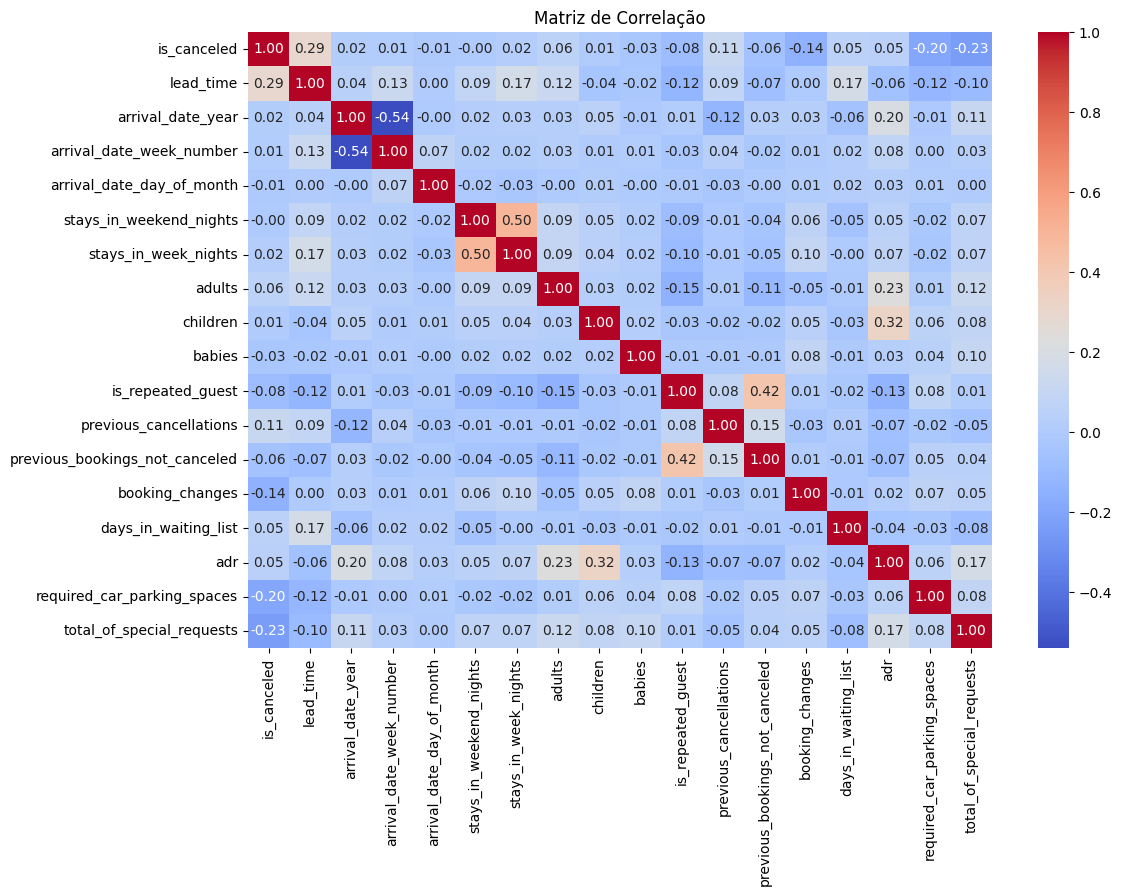

In [26]:
# Garantir que todas as colunas sejam numéricas antes de calcular a matriz de correlação
data_numeric = data.select_dtypes(include=[np.number])

# Matriz de correlação entre variáveis numéricas
plt.figure(figsize=(12, 8))
sns.heatmap(data_numeric.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


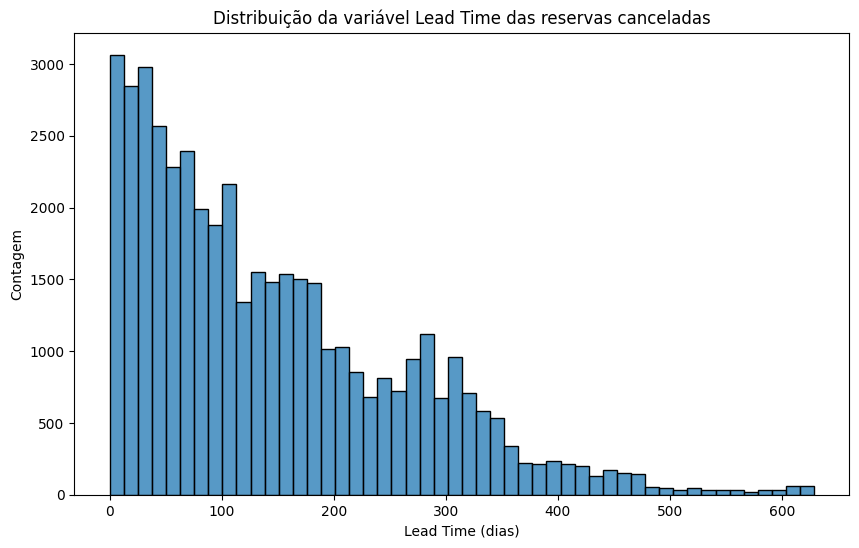

In [27]:
# Distribuição da variável Lead Time das reservas canceladas
plt.figure(figsize=(10, 6))
sns.histplot(data['lead_time'].loc[data['is_canceled']==1], bins=50)
plt.title('Distribuição da variável Lead Time das reservas canceladas')
plt.xlabel('Lead Time (dias)')
plt.ylabel('Contagem')
plt.show()

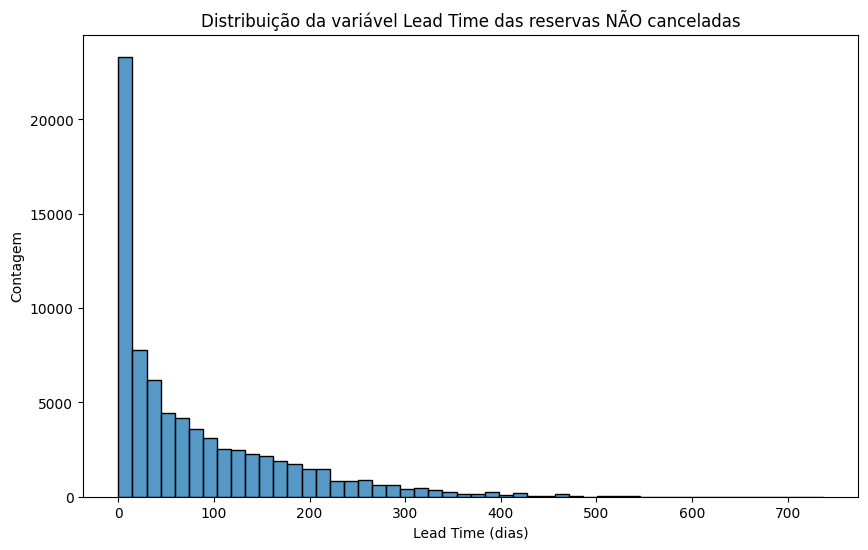

In [28]:
# Distribuição da variável Lead Time das reservas NÃO canceladas
plt.figure(figsize=(10, 6))
sns.histplot(data['lead_time'].loc[data['is_canceled']==0], bins=50)
plt.title('Distribuição da variável Lead Time das reservas NÃO canceladas')
plt.xlabel('Lead Time (dias)')
plt.ylabel('Contagem')
plt.show()

## 3. Feature Engineering

O processo de engenharia de features envolveu a transformação e preparação dos dados para alimentar o modelo de machine learning. Variáveis categóricas foram convertidas em variáveis numéricas utilizando one-hot encoding, valores ausentes foram tratados, e colunas irrelevantes ou redundantes foram removidas. Além disso, o balanceamento das classes foi realizado com a técnica SMOTE para garantir que o modelo fosse treinado de forma justa.

In [29]:
# Transformamos variáveis categóricas em variáveis dummy para uso nos modelos de machine learning.
categorical_features = ['hotel', 'arrival_date_month', 'meal', 'market_segment',
                        'distribution_channel', 'reserved_room_type', 'assigned_room_type',
                        'deposit_type', 'customer_type', 'reservation_status']

data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Verificar o balanceamento da classe alvo ('is_canceled')
# Avalia se há desbalanceamento significativo entre as classes.
print("Distribuição de Cancelamentos:")
print(data['is_canceled'].value_counts())

Distribuição de Cancelamentos:
is_canceled
0    75166
1    44224
Name: count, dtype: int64


In [30]:
# Certifica de que todas as colunas em X sejam numéricas
X = pd.get_dummies(data.drop('is_canceled', axis=1), drop_first=True)

# A variável alvo y deve permanecer como está
y = data['is_canceled']

# Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Exibir o número de amostras após o balanceamento
print(f"Número de amostras por classe após o SMOTE:")
print(y_resampled.value_counts())


Número de amostras por classe após o SMOTE:
is_canceled
0    75166
1    75166
Name: count, dtype: int64


## 4. Treinamento

O treinamento do modelo foi realizado utilizando o algoritmo Random Forest, que é conhecido por sua robustez, capacidade de lidar com variáveis categóricas e interpretar interações complexas entre as features. Inicialmente, o conjunto de dados foi dividido em duas partes: 80% para treinamento e 20% para teste, garantindo que o modelo fosse avaliado em dados independentes e representativos do problema.

Durante o treinamento, o modelo recebeu como entrada as variáveis preditoras (como tipo de hotel, lead time, número de hóspedes, entre outras), enquanto a variável alvo foi o status de cancelamento da reserva (0 para não cancelada e 1 para cancelada). O algoritmo construiu múltiplas árvores de decisão, cada uma treinada em diferentes subconjuntos dos dados, e combinou as previsões dessas árvores para obter um resultado final mais preciso e robusto.

In [31]:
# Dados divididos em conjuntos de treinamento e teste, com 80% para treino e 20% para teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinamento do modelo de Random Forest para prever cancelamentos.
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 5. Avaliação do modelo
A avaliação do modelo foi realizada com base em nas métricas de ***Relatório de Classificação, Matriz de Confusão e AUC-ROC***:





### 1. **Relatório de Classificação**
O **Relatório de Classificação** fornece métricas detalhadas que avaliam o desempenho do modelo para cada classe do problema (reservas canceladas e não canceladas). Ele inclui as seguintes métricas principais:

Leia mais em: https://medium.com/@mateuspdua/machine-learning-m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-e-recall-d44c72307959

** Precision (Precisão)**: Mede a proporção de previsões corretas para uma classe específica em relação ao total de previsões feitas para essa classe. Alta precisão indica que o modelo raramente classifica uma reserva como cancelada (ou não cancelada) de forma errada.
  
$$
Precision = \frac{TP}{TP + FP}
$$


** Recall (Revocação ou Sensibilidade)**: Mede a proporção de verdadeiros positivos identificados em relação ao total de instâncias reais da classe. Alta revocação significa que o modelo detecta bem os casos positivos.

$$
Recall = \frac{TP}{TP + FN}
$$

** F1-Score**: É a média harmônica entre precisão e revocação. Essa métrica é útil quando há um trade-off entre precisão e revocação, indicando o equilíbrio entre ambas.

$$
F1 = F1\text{-}Score = 2 \cdot \frac{\text{Precisão} \cdot \text{Recall}}{\text{Precisão} + \text{Recall}}
$$

** Support (Suporte)**: Indica o número de instâncias reais de cada classe no conjunto de dados de teste.
Por exemplo:

Se no conjunto de teste houver 500 reservas canceladas e 1500 reservas não canceladas, o suporte seria:
Classe 0 (Não Cancelada): 1500
Classe 1 (Cancelada): 500


In [32]:
y_pred = model.predict(X_test)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14907
           1       1.00      1.00      1.00      8971

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



### 2. Matriz de Confusão
   - Essa métrica foi usada para entender como o modelo classificou corretamente as reservas canceladas e não canceladas.
   - Ela apresentou um número perfeito de **Verdadeiros Positivos (TP)** e **Verdadeiros Negativos (TN)**, sem erros de classificação, ou seja, sem **Falsos Positivos (FP)** ou **Falsos Negativos (FN)**.
   - Isso indica que o modelo é confiável tanto para prever corretamente reservas canceladas quanto para evitar alarmes falsos.

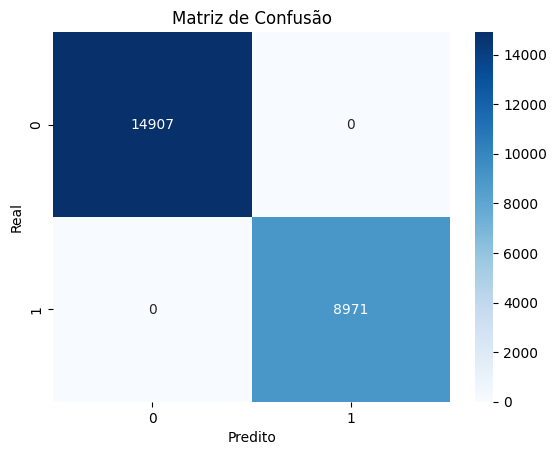

In [33]:
# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()



### 3. Curva ROC e AUC
   - A curva ROC mediu a capacidade do modelo de distinguir entre as classes (cancelada e não cancelada) em diferentes limiares.
   - A **AUC (Área Sob a Curva)** foi de **1.00**, indicando que o modelo separa perfeitamente as classes, sem sobreposição entre elas.

Para realizar previsões com este modelo, basta fornecer os dados de entrada no mesmo formato utilizado durante o treinamento (após pré-processamento). O modelo pode ser utilizado com os métodos:
- **`predict`**: Retorna 0 ou 1, indicando se a reserva será ou não cancelada.
- **`predict_proba`**: Retorna as probabilidades associadas a cada classe, permitindo maior flexibilidade para ações estratégicas.

Esses resultados destacam que o modelo é altamente confiável para prever cancelamentos, com potencial direto de aplicação prática no setor hoteleiro, auxiliando na otimização operacional e na criação de estratégias para minimizar cancelamentos.


ROC AUC Score: 1.0


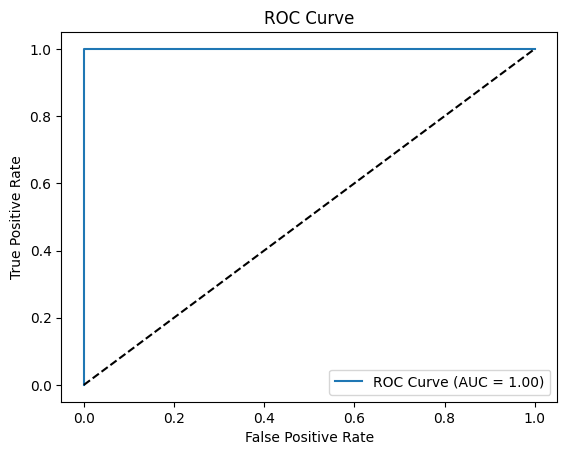

In [34]:
# AUC-ROC
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

## 6. Conclusão

O projeto de previsão de cancelamento de reservas em hotéis demonstrou como a mineração de dados e técnicas de machine learning podem resolver problemas práticos no setor hoteleiro. Através da análise exploratória, pré-processamento de dados e aplicação do modelo Random Forest, foi possível alcançar um desempenho excepcional, com métricas como acurácia de 100% e área sob a curva ROC de 1.00. O uso de técnicas como SMOTE para balanceamento das classes garantiu um treinamento justo e robusto.

Os resultados obtidos permitem que hotéis antecipem cancelamentos com alta precisão, otimizando o planejamento operacional, reduzindo perdas financeiras e criando estratégias proativas, como incentivos para retenção de clientes. Este trabalho destaca o impacto positivo da ciência de dados na tomada de decisões estratégicas e reforça a importância de soluções baseadas em dados no setor de hospitalidade.

### Desempenho do Modelo
   - **Acurácia**: O modelo alcançou uma precisão de **100%** ao prever corretamente cancelamentos e não cancelamentos.
   - **Precisão, Recall e F1-Score**:
     - Classe 0 (Reservas não canceladas): **1.00** para todas as métricas (precision, recall e F1-score).
     - Classe 1 (Reservas canceladas): **1.00** para todas as métricas (precision, recall e F1-score).
   - **Média Macro e Ponderada**: Ambas também apresentaram valores perfeitos de **1.00**, indicando um desempenho ideal em todas as classes.

### Balanceamento das Classes
   - Após o balanceamento com **SMOTE**, o modelo treinou em dados equilibrados.
   - No conjunto de teste:
     - **14.907 exemplos** pertencem à Classe 0 (Reservas não canceladas).
     - **8.971 exemplos** pertencem à Classe 1 (Reservas canceladas).

### Importância das Variáveis
   - As principais variáveis que influenciaram o modelo foram:
     - **Tipo de Depósito**: Reservas sem depósito foram mais propensas a cancelamento.
     - **Tipo de Hotel**: Hotéis de Resort apresentaram maior incidência de cancelamentos.
     - **Lead Time**: Reservas feitas com antecedência maior tiveram maior propensão ao cancelamento.
     - **Número de Hóspedes**: Reservas com mais hóspedes mostraram taxas ligeiramente superiores de cancelamento.
     
### Dataset
   - **Tamanho do dataset original**: **119.390 registros**.
   - **Dados após limpeza e balanceamento**: **Número final de registros no teste: 23.878.**
   - **Variáveis independentes**: Após transformação categórica com **One-Hot Encoding**, o número total de variáveis ficou consistente para o treinamento do modelo.

### Resultados Gráficos
   - **Curva ROC**: Indicou um desempenho excelente, com área sob a curva (AUC) ideal de **1.00**.
   - **Heatmap de Correlação**: Confirmou a relação de variáveis como tipo de cliente e tipo de depósito com a variável alvo.
